In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import math
import random as ran
from scipy.stats import truncnorm
import pandas as pd
import seaborn as sbn
import time

In [2]:
#timeseries data
all_data=pd.read_csv('./data/Timeseries_data_SP500.csv')
date_list=list(set(list(all_data['DATE'])))
for i in range(len(date_list)):
    ak=date_list[i]
    date_list[i]=ak[6:]+str('-')+ak[:2]+'-'+ak[3:5]
date_list.sort()
all_data['DATE']=pd.to_datetime(all_data['DATE'])
all_data=all_data.rename(columns={'NAME':'name','DATE':'date','SEDOL':'sedol','SECTOR':'sector','BETA':'beta','ALPHA_SCORE':'as','BENCH_WEIGHT':'bw',"MCAP_Q":'mq'})
sedol_list=all_data['sedol'].unique().tolist()

dic_data = {k: v for k, v in all_data.groupby('date')}

#risk:cov_mat
def risk(date_str):
    risk_data=pd.read_csv('./data/Riskmodels/cov_mat_%s.csv'%(date_str))
    risk_sedol=risk_data['ROW_INDEX'].unique().tolist()
    risk_mat = np.zeros((len(risk_sedol),len(risk_sedol)))
    risk_mat[np.triu_indices(len(risk_sedol), 0)] = list(risk_data['VALUE'])
    irows,icols = np.triu_indices(len(risk_sedol),0)
    risk_mat[icols,irows]=risk_mat[irows,icols]
    return risk_data,risk_sedol,risk_mat
risk_data,risk_sedol,risk_mat=risk(date_list[0])

dic_data[list(dic_data.keys())[0]]['index']=list(dic_data[list(dic_data.keys())[0]].index)

bw=list(dic_data[list(dic_data.keys())[0]]['bw'])
bw=np.array(bw)


beta=list(dic_data[list(dic_data.keys())[0]]['beta'])
beta=np.array(beta)

alpha=list(dic_data[list(dic_data.keys())[0]]['as'])
alpha=np.array(alpha)
#alpha=alpha.reshape(1,len(bw))

sector_set = set(list(dic_data[list(dic_data.keys())[0]]['sector']))
sector_list = list(dic_data[list(dic_data.keys())[0]]['sector'])

gbs=dic_data[list(dic_data.keys())[0]][['sector', 'index']].apply(tuple, axis=1)
group_by_sector = [[y[1] for y in gbs if y[0]==x] for x in sector_set]

mq_list=list(dic_data[list(dic_data.keys())[0]]['mq'])
mq_set=set(list(dic_data[list(dic_data.keys())[0]]['mq']))

gbm=dic_data[list(dic_data.keys())[0]][['mq', 'index']].apply(tuple, axis=1)
group_by_mq = [[y[1] for y in gbm if y[0]==x] for x in mq_set]

nbasset=len(bw)
nbsector=len(sector_set)
nbmq=len(mq_set)

In [48]:
def sample_Z(m, n):
    return Variable(torch.Tensor(np.random.uniform(-1., 1., size=[m, n])))


class PlotLosses:
    def __init__(self):
        self.i = 0
        self.x = []
        self.losses = []
        
        self.fig = plt.figure()
        
        self.bins = np.linspace(0, 1, num=20)

    def update_plots(self, it, loss, sample_D_values=[], best_obj=0, elapsed_time=0):
        
        self.x.append(self.i)
        self.losses.append(loss)
        self.i += it

        clear_output(wait=True)

        f, (ax1, ax2) = plt.subplots(1, 2, sharex=False)
        f.set_size_inches(12,4)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.set_title('Generator loss')
        ax1.annotate(f'Current loss={loss:.4f}', xy=(0.5,0.5), xycoords='axes fraction')
        ax1.annotate(f'Best Obj={best_obj:.4f}', xy=(0.5,0.6), xycoords='axes fraction')
        ax1.annotate(f'Elap. time={elapsed_time:.2f} sec.', xy=(0.5,0.7), xycoords='axes fraction')
        ax1.legend()
        
        try:
            sbn.kdeplot(sample_D_values, ax=ax2, shade=True)
    #         ax2.hist(sample_D_values, bins=self.bins, label="P(sample is feasible)")
            ax2.set_title('Sample Discriminator Outputs (KDE)')
            ax2.set_xlim(0, 1.1)
            
        except:
            pass


        plt.show()

        
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return np.random.normal(size=size, scale=xavier_stddev)


class Generator(nn.Module):
    def __init__(self,  in_dim=10, hd_dim=50, out_dim=nbasset):
        super(Generator, self).__init__()
        
        self.G_W1 = nn.Parameter(torch.from_numpy(xavier_init([in_dim, hd_dim])).float())
        self.G_b1 = nn.Parameter(torch.from_numpy(np.zeros(shape=[hd_dim])).float())
        
        self.G_W2 = nn.Parameter(torch.from_numpy(xavier_init([hd_dim, out_dim])).float())
        self.G_b2 = nn.Parameter(torch.from_numpy(np.zeros(shape=[out_dim])).float())

    def forward(self, x):
        x = F.relu( x @ self.G_W1 + self.G_b1)
        x = x @ self.G_W2 + self.G_b2
        return F.sigmoid(x)


class Discriminator(nn.Module):
    def __init__(self, in_dim=nbasset,train=False):
        super(Discriminator, self).__init__()
        self.tot_infs = 0.0
        self.tot_infs_nor = 0.0
        self.train = train
        self.x_threshold = 0.001
        self.inf_scale = 100.0
        self.Zstar = 1000
        
        self.in_dim = in_dim

        np.random.seed(0)
        self.Omega = Variable(torch.from_numpy(risk_mat)).float()

        self.card_upper = 50.
        self.card_lower = 70.
        
        
    def forward(self, x):
        tot_infs = Variable(torch.zeros(x.size()[0]))
        x_bw = Variable(torch.from_numpy(bw).float())
        alp = Variable(torch.Tensor(alpha).float())   
        beta = Variable(torch.Tensor(beta).float())
 
        # (4)
        tot_infs += F.relu(1. - torch.sum(x,1))
        tot_infs += F.relu(torch.sum(x,1) - 1.)
        
        # (5)
        tot_infs += F.relu(torch.abs(x-x_bw)@ Variable(torch.ones(self.in_dim))-0.05)
        
        
        # (6)
        for j in range(nbsector):
            k= (x-x_bw) @ Variable(
                torch.Tensor([1 if i in group_by_sector[j] else 0 for i in range(self.in_dim)]).float())  #sum
            l = torch.abs(k)
            tot_infs += F.relu(l - 0.1)
            
        # (7)
        for j in range(nbmq):
            k = (x-x_bw) @ Variable(
                torch.Tensor([1 if i in group_by_mq[j] else 0 for i in range(self.in_dim)]).float())  #sum
            l = torch.abs(k)
            tot_infs += F.relu(l - 0.1)
            
        # (8)
        k = (x-x_bw)@beta
        l = torch.abs(k)
        tot_infs += F.relu(l - 0.1)
        
        # (9) lb <= card(x) <= b
        if self.train:
            num_non_zeros = torch.sum(torch.tanh(x / self.x_threshold), 1)
            tot_infs += F.relu(num_non_zeros - self.card_upper) + F.relu(self.card_lower - num_non_zeros)
        else:
            num_non_zeros = torch.sum(x.data>self.x_threshold, 1).float()
            tot_infs += Variable(np.maximum(num_non_zeros - self.card_upper, 0) + np.maximum(self.card_lower - num_non_zeros, 0))
    
        
        # (10)
        l = 0.5*torch.sum(torch.abs(x - x_bw)*x)
        tot_infs += F.relu(0.6 - l)
    
        
        # (11) a<=dQd <= b
        dQ = (x-x_bw) @ self.Omega
        size_x = x.size()
        dQd = torch.bmm(dQ.view(size_x[0],1,size_x[1]), (x-x_bw).view(size_x[0],size_x[1],1)).squeeze(1).squeeze(1)
        tot_infs += F.relu(dQd - 0.01)
        tot_infs += F.relu(0.0025 - dQd)
        
        
        # min dQd + ad (<= Zstar)
        l = (x-x_bw)@alp
        tot_infs += F.relu(dQd - l - self.Zstar)
        self.objs = dQd - l

            
        fea_probs = F.relu(1. - F.tanh(tot_infs/self.inf_scale))
        
        
        return fea_probs
        


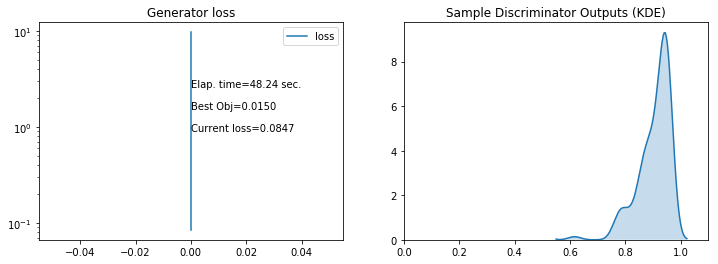

KeyboardInterrupt: 

In [62]:
X_dim = nbasset
HL_dim = 50
Z_dim = 10


loss_plot = PlotLosses()


G = Generator(Z_dim, HL_dim, X_dim)

sample_D = Discriminator(X_dim, train=False)
train_D = Discriminator(X_dim, train=True)

G_solver = optim.Adam(G.parameters(), lr=1e-3)


mb_size = 128

best_obj = 100000.0
best_sols = []

losses = []

start_time = time.time()

feasible_threshold = 0.995

adaptive_inf_scale = float(nbasset)

for it in range(20000):
    if it % 1000 == 0:
        sample_noise = sample_Z(128, Z_dim)
        samples = G(sample_noise)

        sample_D.Zstar = best_obj
        sample_D.inf_scale = adaptive_inf_scale
        
        sample_D_values = sample_D(samples).data.numpy()
        sample_obj_values = sample_D.objs.data.numpy()
                
        fea_sample_obj_values = sample_obj_values[sample_D_values > feasible_threshold]
        sols = samples.data.numpy()[sample_D_values > feasible_threshold]
        if len(fea_sample_obj_values > 0):
            best_idx = np.argmin(fea_sample_obj_values)
            if np.min(fea_sample_obj_values) < best_obj:
                best_obj = np.minimum(fea_sample_obj_values[best_idx], best_obj)
                best_sols.append(sols[best_idx])

    z = Variable(torch.randn(mb_size, Z_dim))
    
    train_D.Zstar = best_obj
    train_D.inf_scale = adaptive_inf_scale
 
    G_loss = -torch.mean(torch.log(train_D(G(z))))
    
    
    G.zero_grad()
    G_loss.backward()
    G_solver.step()

    

    if it % 1000 == 0:
        
        loss_plot.update_plots(
            it=it, 
            loss=G_loss.data[0], 
            sample_D_values=sample_D_values,
            best_obj=best_obj,
            elapsed_time=time.time()-start_time
        )
        
        losses.append(G_loss)
        

￼result..!
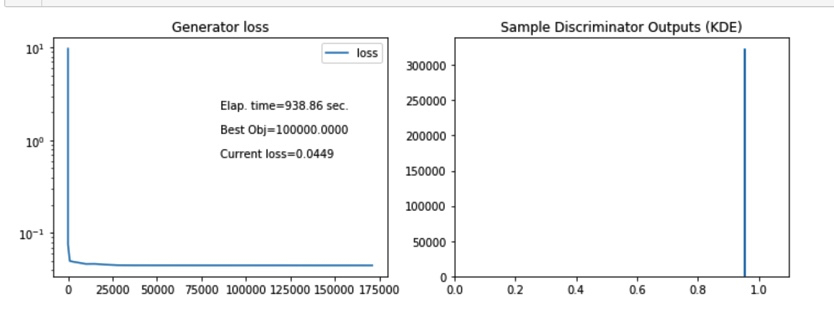